In [ ]:
pip install -r requirements.txt

In [1]:
# https://poalim.tistory.com/m/29
# https://github.com/poArlim/crypto-auto-trading

import pyupbit
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


coin = "KRW-BTC"		# 코인명
interval = "day"		# 일간 차트 기준
fees = 0.0005			# 수수료
day_count = 1300		# 가져오는 총 데이터 일 수(1300일치 데이터)

# K의 역할
# K는 변동폭을 얼마나 반영할지 결정하는 조정 계수입니다.
# K = 1: 전날 변동폭 100% 반영.
# → 목표 매수가 = 시가 + 전날 변동폭 전체.
# K = 0: 전날 변동폭을 전혀 반영하지 않음.
# → 목표 매수가 = 시가.

# 0 < K < 1: 전날 변동폭을 부분적으로 반영.
# → 목표 매수가는 시가와 변동폭의 비율에 따라 조정됨.
# K는 매수 기준을 조정하는 변수입니다.
# 높은 K는 더 큰 변동성을 노리지만, 거래 빈도가 줄어들 수 있습니다.
# 낮은 K는 더 자주 거래하지만, 변동성 활용도가 낮아질 수 있습니다.
# 적절한 K 값을 찾기 위해 백테스트가 필요합니다.

# K가 수익에 미치는 영향
# K 값에 따라 매수 타이밍이 달라지며, 수익률과 리스크가 변합니다:
# K가 높을수록 (1에 가까울수록):
# 더 높은 변동성을 목표로 매수.
# → 큰 가격 움직임을 노리지만, 매수 확률이 낮아질 수 있음.
# K가 낮을수록 (0에 가까울수록):
# 작은 변동성에도 매수.
# → 매수 기회가 많아지지만, 수익률이 낮아질 가능성이 있음.
K = 0.5

date = None             # 데이터를 반복적으로 가져올 때 기준 날짜를 설정
dfs = []                # 가져온 데이터를 저장할 리스트

# 업비트는 한번에 200 데이터만 반환하기 때문에 데이터를 나누어 여러번 요청
# day_count // 200: 데이터를 200일씩 분할
# +1: 남은 데이터를 처리하기 위해 추가 반복
for i in range(day_count // 200 + 1):

    # 초기 데이터 요청
    # 첫 번째 요청 시 date는 None이므로 가장 최신 데이터를 가져옴
    # df.index[0]: 반환된 데이터의 첫 번째 날짜를 가져와 date에 저장
    if i < day_count // 200 :
        df = pyupbit.get_ohlcv(coin, to = date, interval = interval)
        date = df.index[0]

    # 남은 데이터 요청
    # elif day_count % 200 != 0: 요청한 총 데이터가 200의 배수가 아닐 경우 남은 데이터를 가져옴
    elif day_count % 200 != 0 :
        df = pyupbit.get_ohlcv(coin, to = date, interval = interval, count = day_count % 200)
    
    # 필요한 데이터를 모두 가져왔으면 반복을 종료
    else :
        break
    dfs.append(df)
    time.sleep(0.1)

# 각 반복에서 가져온 데이터를 dfs 리스트에 저장한 후, Pandas의 concat 함수를 이용해 병합.
# 날짜순으로 정렬하여 최종 데이터프레임(df) 생성.
df = pd.concat(dfs).sort_index()
display(df)

# open(시가), high(고가), low(저가), close(종가), volume(거래량)

df['range'] = df['high'].shift(1) - df['low'].shift(1)
df['targetPrice'] = df['open'] + df['range'] * K
df['drr'] = np.where(df['high'] > df['targetPrice'], (df['close'] / (1 + fees)) / (df['targetPrice'] * (1 + fees)) - 1 , 0)

df['crr'] = (df['drr'] + 1).cumprod() - 1
df['dd'] = -(((df['crr'] + 1).cummax() - (df['crr'] + 1)) / (df['crr'] + 1).cummax())

print("기간수익률 :", df['crr'].iloc[-1] * 100, "% , 최대손실률 :", df['dd'].min() * 100, "% , 수수료 :", fees * 100, "%")
print("알고리즘 적용 없을 시 수익률 :", ((df['close'].iloc[-1]/(1+fees))/(df['open'].iloc[0]*(1+fees))-1) * 100, "%")

df.to_excel("crypto_history.xlsx")

,open,high,low,close,volume,value
2021-06-17 09:00:00,45306000.0,46048000.0,44390000.0,44854000.0,10707.197040,4.857628e+11
2021-06-18 09:00:00,44823000.0,44945000.0,42191000.0,42599000.0,15162.184462,6.634732e+11
2021-06-19 09:00:00,42588000.0,43000000.0,41364000.0,42088000.0,9403.803546,3.965329e+11
2021-06-20 09:00:00,42088000.0,42443000.0,39785000.0,41842000.0,13184.495902,5.427276e+11
2021-06-21 09:00:00,41843000.0,42048000.0,36802000.0,37393000.0,23102.561338,9.008327e+11
...,...,...,...,...,...,...
2024-12-27 09:00:00,144016000.0,146117000.0,141466000.0,142111000.0,3231.263284,4.646690e+11
2024-12-28 09:00:00,142107000.0,143000000.0,141487000.0,142302000.0,1311.563873,1.863486e+11
2024-12-29 09:00:00,142306000.0,142380000.0,138600000.0,139735000.0,2180.406377,3.065153e+11
2024-12-30 09:00:00,139831000.0,140680000.0,135971000.0,137892000.0,3767.669781,5.208487e+11


기간수익률 : 56.26240261435951 % , 최대손실률 : -49.48983425901699 % , 수수료 : 0.05 %
알고리즘 적용 없을 시 수익률 : 201.38044065179602 %


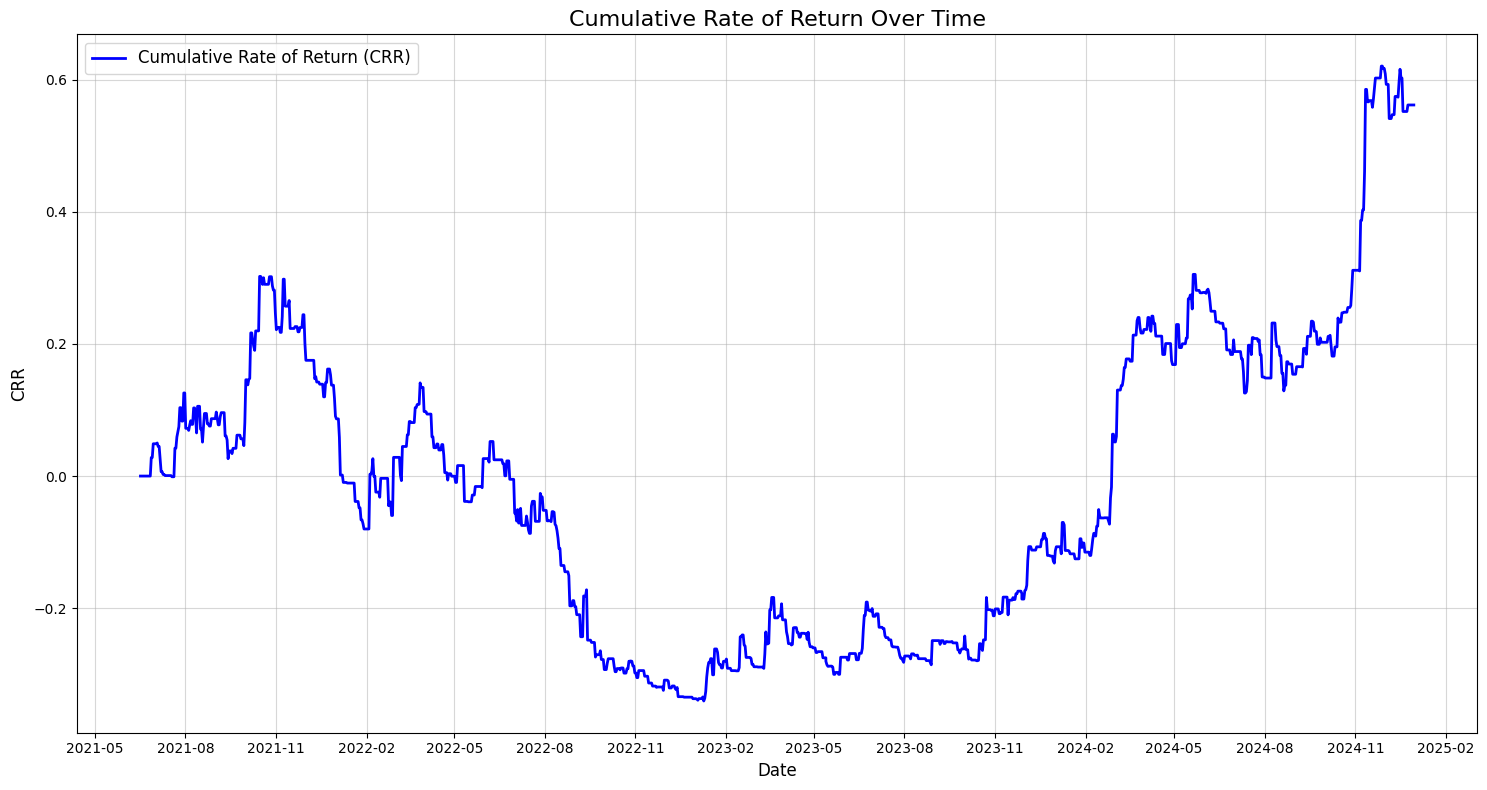

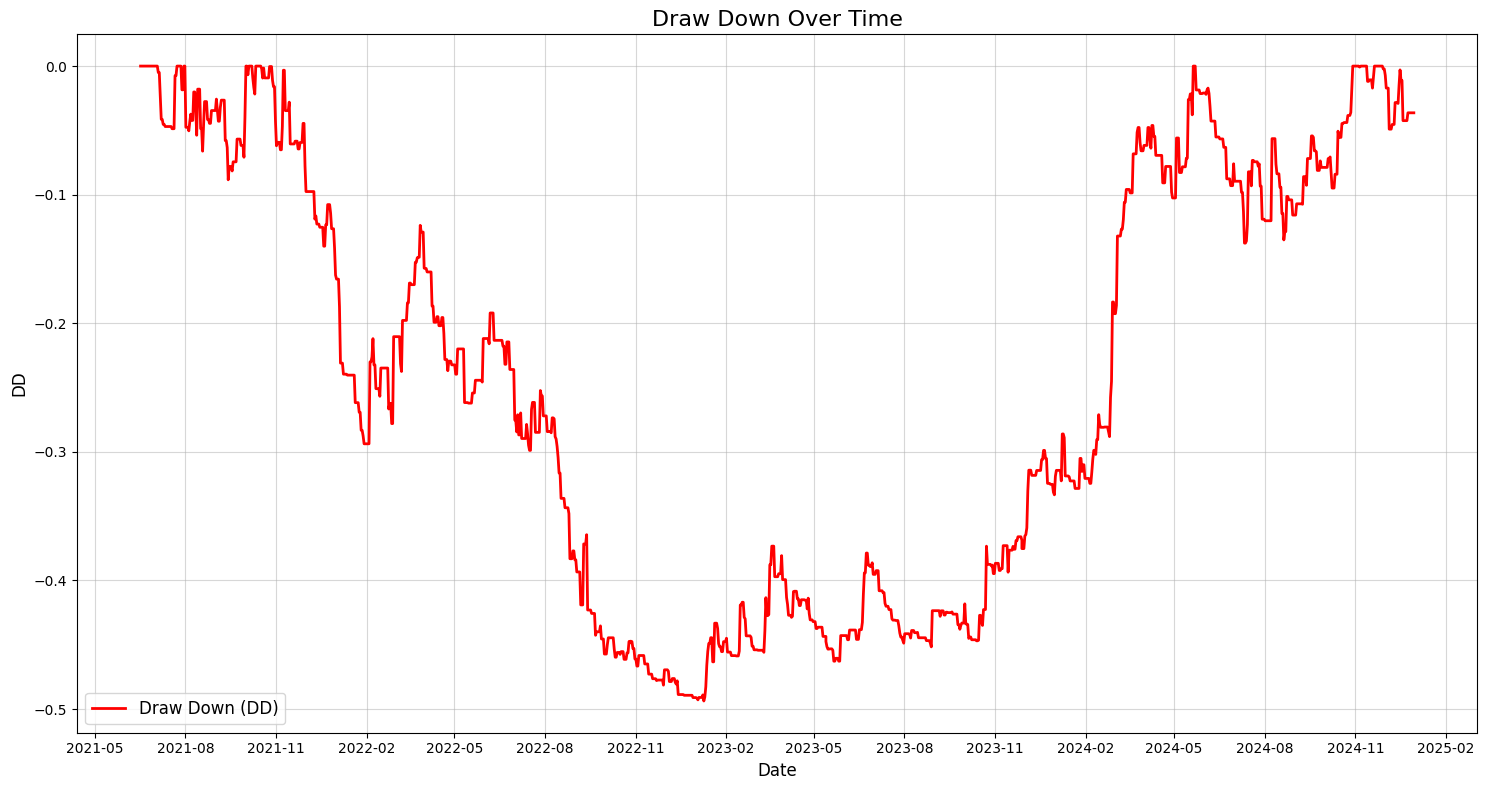

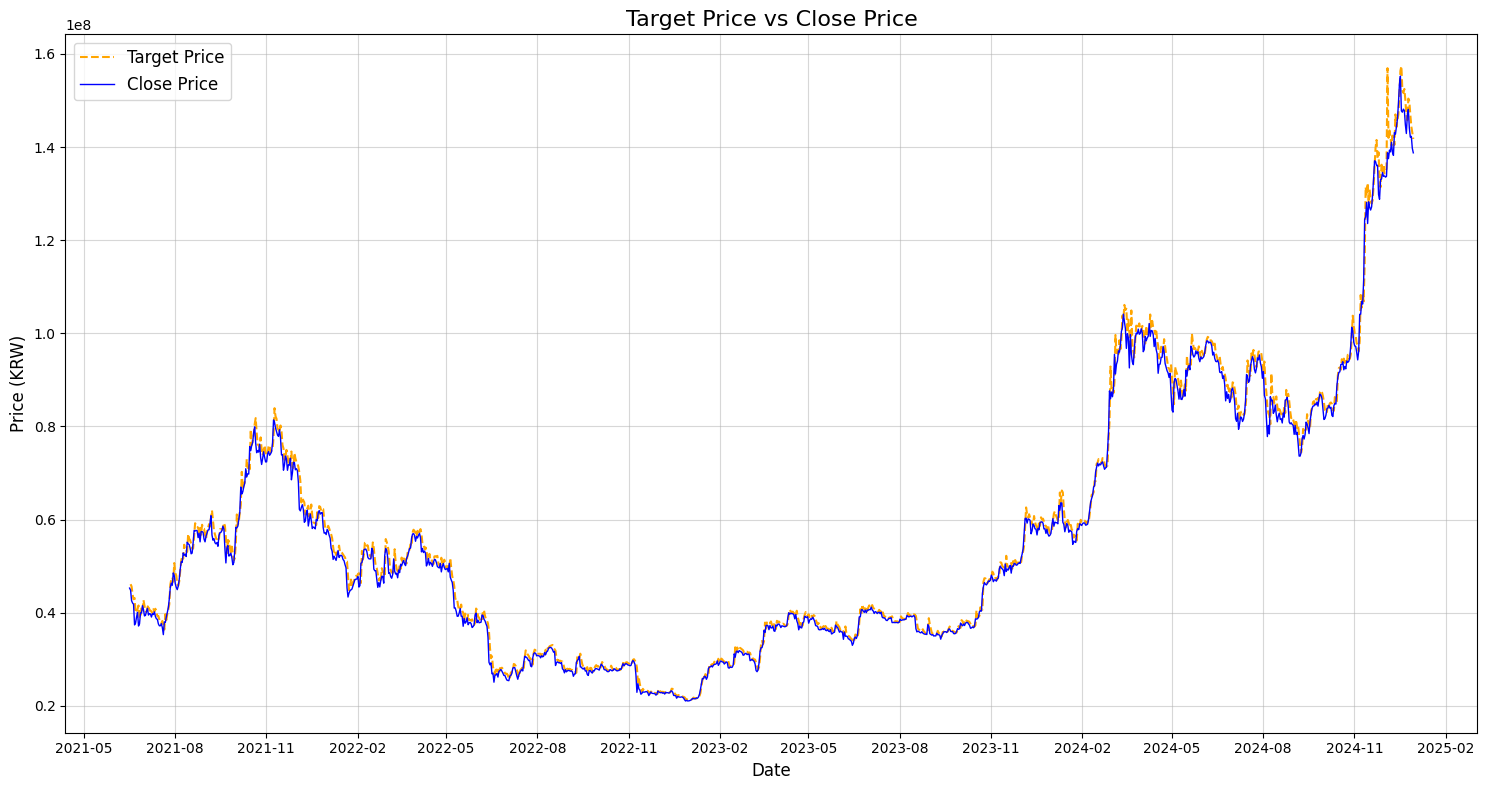

In [24]:
import matplotlib.dates as mdates

# Visualization
# Plotting Cumulative Rate of Return (CRR)
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['crr'], label="Cumulative Rate of Return (CRR)", linewidth=2, color='blue')
plt.title("Cumulative Rate of Return Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("CRR", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting Draw Down (DD)
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['dd'], label="Draw Down (DD)", color='red', linewidth=2)
plt.title("Draw Down Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("DD", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting Target Price vs Close Price
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['targetPrice'], label="Target Price", color='orange', linestyle='--')
plt.plot(df.index, df['close'], label="Close Price", color='blue', linewidth=1)
plt.title("Target Price vs Close Price", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (KRW)", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Target Price란?
# 목표 가격은 특정 거래 전략에서 "이 가격 이상이 되면 매수하자"라고 설정한 기준 가격입니다.
# 예를 들어, 비트코인의 전날 가격 변동성을 이용해서 다음 날의 매수 기준을 정하는 거예요.
# 공식:
# targetPrice = open + range * K
# open: 오늘의 시작 가격 (시가)
# range: 전날의 고가 - 전날의 저가
# K: 변동성을 얼마나 반영할지 결정하는 비율 (여기서는 0.5)

# Close Price란?
# 종가는 하루가 끝났을 때 실제로 비트코인이 거래된 마지막 가격입니다.
# 즉, 실제 시장에서 기록된 마지막 가격이에요.

# 그래프에서 무엇을 비교하나요?
# Target Price (목표 가격):
# 우리가 정한 매수 기준입니다.
# 만약 종가가 목표 가격을 넘었다면, "이 전략대로 했다면 수익이 났을 가능성이 있다"고 볼 수 있습니다.
# Close Price (종가):
# 실제로 하루를 마감한 가격입니다.
# 목표 가격보다 높으면 전략이 성공했다고 볼 수 있고, 낮으면 실패했다고 볼 수 있습니다.

# 왜 중요한가요?
# 전략 평가:
# 목표 가격을 설정하고, 실제 가격과 비교해서 "전략이 유효한지" 확인할 수 있습니다.
# 예를 들어:
# 종가가 목표 가격을 자주 넘는다면: 전략이 잘 작동한 것.
# 종가가 목표 가격보다 낮다면: 전략을 수정하거나 K 값을 조정해야 할 수 있음.

# 더 쉽게 예를 들면:
# 오늘의 시가(Open): 10,000원
# 전날의 고가(High): 12,000원
# 전날의 저가(Low): 8,000원
# K 값: 0.5
# 목표 가격(Target Price):
# Target Price = 10,000 + (12,000 - 8,000) * 0.5
#               = 12,000원
# 종가(Close Price):
# 실제 하루가 끝났을 때 기록된 가격이 12,500원이라고 가정.
# => 이 경우 **종가(12,500원)**가 **목표 가격(12,000원)**을 초과했으므로, 전략이 수익을 낼 수 있었던 날입니다.

# 그래프의 모습
# 주황색 선 (Target Price): 목표 가격
# 파란색 선 (Close Price): 실제 마감된 가격
# 파란색 선이 주황색 선 위에 있으면: 전략이 수익이 났을 가능성이 큽니다.
# 파란색 선이 주황색 선 아래에 있으면: 전략이 실패했을 가능성이 큽니다.
